We need to understand how the JS Divergence behaves as a function of beta.  
So we will generate two groups of trials, using poisson populations with fixed rates, different for each group.


In [1]:
import numpy as np
import neuraltda.simpComp as sc
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline


In [16]:
def generate_poisson_population(ncells, ntimes, rate):
    samps = np.random.rand(ncells, ntimes)
    binmat = np.greater(rate, samps).astype(int)
    return binmat

def generate_trials(ncells, ntimes, trials_per_group, ngroups, rates):
    trials = []
    for ind, grp in enumerate(range(ngroups)):
        for t in range(trials_per_group):
            tx = generate_poisson_population(ncells, ntimes, rates[ind])
            trials.append(tx)
    return trials

def lapspectrum(trial, dim):
    ms = sc.binarytomaxsimplex(trial, rDup=True)
    scg = sc.simplicialChainGroups(ms)
    lap = sc.sparse_laplacian(scg, dim)
    lapspectra = sc.sparse_spectrum(lap)
    return (lap, lapspectra)

def get_laplacian_spectra(trials, dim):
    dat = Parallel(n_jobs=24)(delayed(lapspectrum)(t, dim) for t in trials)
    laps = [x[0] for x in dat]
    lapspectra = [x[1] for x in dat]
    return (laps, lapspectra)
        
def get_M(i, j, L1, L2):
    mspec = sc.compute_M_spec(L1, L2)
    print((i, j))
    return (i, j, mspec)

def get_m_spectra(laps):
    # Precompute M spectra
    N = len(laps)
    pairs = [(i, j) for i in range(N) for j in range(i, N)]
    print('Computing M spectra...')
    M_spec = Parallel(n_jobs=24)(delayed(get_M)(i, j, laps[i], laps[j]) for (i, j) in pairs)
    M_spec = {(p[0], p[1]): p[2] for p in M_spec}
    return M_spec

def get_JS_spec(i, j, speci, specj, specm, beta):
    js = (i, j, sc.sparse_JS_divergence2_spec(speci, specj, specm, beta))
    return js

def compute_JS_div_mtx(lapspectra, Mspectra, beta):
    N = len(lapspectra)
    pairs = [(i, j) for i in range(N) for j in range(i, N)]
    #print('Computing JS Divergences with beta {}...'.format(beta))
    jsmat = np.zeros((N, N))

    jsdat = Parallel(n_jobs=24)(delayed(get_JS_spec)(i, j, lapspectra[i], lapspectra[j], Mspectra[(i,j)], beta) for (i, j) in pairs)
    for d in jsdat:
        jsmat[d[0], d[1]] = d[2]
    return jsmat


def compute_within_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within)

def compute_withins_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within1, within2)

In [6]:
trials = generate_trials(100, 1000, 20, 2, [0.01, 0.02])
(laps, lapspectra) = get_laplacian_spectra(trials, 1)
mspectra = get_m_spectra(laps)

Computing M spectra...


/home/AD/btheilma/anaconda3/envs/neuraltda-4/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [28]:
betas = np.logspace(-1, 2)
nstim = 2
ntrials=20

btwn_means = np.zeros(len(betas))
btwn_stds = np.zeros(len(betas))
wthn_means = np.zeros(len(betas))
wthn_stds = np.zeros(len(betas))
wthn1_means = np.zeros(len(betas))
wthn1_stds = np.zeros(len(betas))
wthn2_means = np.zeros(len(betas))
wthn2_stds = np.zeros(len(betas))
from tqdm import tqdm_notebook as tqdm

for ind, beta in enumerate(tqdm(betas)):
    mat = compute_JS_div_mtx(lapspectra, mspectra, beta)
    (btwn, wthn1, wthn2) = compute_withins_vs_between(mat, ntrials, nstim, diag=1)
#     btwn = np.sqrt(btwn)
#     wthn1 = np.sqrt(wthn1)
#     wthn2 = np.sqrt(wthn2)
    wthn = np.concatenate((wthn1, wthn2))
    btwn_means[ind] = np.mean(btwn)
    btwn_stds[ind] = np.std(btwn) / np.sqrt(len(btwn))
    wthn_means[ind] = np.mean(wthn)
    wthn_stds[ind] = np.std(wthn) / np.sqrt(len(wthn))
    wthn1_means[ind] = np.mean(wthn1)
    wthn1_stds[ind] = np.std(wthn1) / np.sqrt(len(wthn1))
    wthn2_means[ind] = np.mean(wthn2)
    wthn2_stds[ind] = np.std(wthn2) / np.sqrt(len(wthn2))

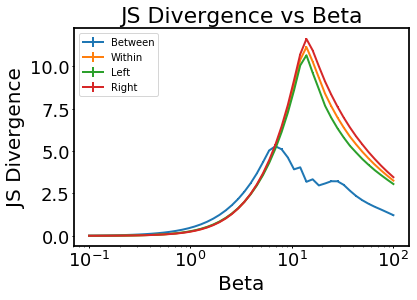

In [29]:
plt.style.use('/home/btheilma/code/NeuralTDA/gentnerlab.mplstyle')
ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
plt.errorbar(betas, btwn_means, yerr=btwn_stds)
plt.errorbar(betas, wthn_means, yerr=wthn_stds)
plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
plt.title('JS Divergence vs Beta')
plt.xlabel('Beta')
plt.ylabel('JS Divergence')
plt.legend(['Between', 'Within', 'Left', 'Right'])

In [25]:
wthn

array([ 0.00000000e+00,  3.16001696e+00,  2.90054601e+00,  3.34007724e+00,
        3.18450689e+00,  3.31343234e+00,  3.24267614e+00,  2.86816662e+00,
        3.22446927e+00,  3.21621382e+00,  2.84681955e+00,  3.34307302e+00,
        2.96398786e+00,  3.29040621e+00,  3.11341063e+00,  3.33409391e+00,
        3.26784342e+00,  2.80674887e+00,  2.94685087e+00,  3.77512596e+00,
        0.00000000e+00,  3.03872954e+00,  3.19238042e+00,  3.01807675e+00,
        3.11540206e+00,  2.99823886e+00,  2.71430419e+00,  3.03595408e+00,
        2.69690579e+00,  3.01905179e+00,  2.98385871e+00,  3.28260517e+00,
        2.89798134e+00,  3.11774700e+00,  2.98972338e+00,  3.11823120e+00,
        2.56121346e+00,  2.64228617e+00,  3.17395297e+00,  0.00000000e+00,
        2.98767106e+00,  3.29439660e+00,  3.17030149e+00,  3.08256871e+00,
        2.83700888e+00,  3.03900871e+00,  3.00420804e+00,  3.11376919e+00,
        3.31138324e+00,  2.97691200e+00,  3.10272352e+00,  2.68764683e+00,
        3.16104350e+00,  